<a href="https://colab.research.google.com/github/TGandhi5473/APANProjects/blob/main/MLModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading in Data and Checking for Missing Values

In [2]:
import pandas as pd
import numpy as np

# Read the data & handle missing values
file_path = '/content/drive/My Drive/MLProjects/analysisData.csv'
data = pd.read_csv(file_path)
data.replace("", np.nan, inplace=True)

# Count NA values in each column
na_empty_count = data.isna().sum()

# Identify columns with NA values
columns_with_na_empty = na_empty_count[na_empty_count > 0].index.tolist()

# Display counts of NA values for columns with NA values
print(na_empty_count[columns_with_na_empty])

# Get the classes of columns with NA values
column_classes = data[columns_with_na_empty].dtypes
print("\n", column_classes)


trim_name                       7
fuel_tank_volume_gallons        5
fuel_type                     671
highway_fuel_economy         5453
city_fuel_economy            5453
power                        5503
torque                       6268
transmission                 1555
transmission_display         1555
wheel_system                  341
wheel_system_display          341
engine_type                   674
engine_displacement           392
horsepower                    392
description                   998
exterior_color               1022
interior_color               7585
major_options                2708
fleet                       23543
frame_damaged               23543
franchise_make              12026
has_accidents               23543
isCab                       23543
is_cpo                      47065
mileage                      2178
owner_count                 24769
salvage                     23543
seller_rating                 678
dtype: int64

 trim_name                    obje

We assume more than 10% missing data is unsuitable for ML algorithims and exclude them from analysis.

In [3]:
# Calculate missing percentage for each column
missing_percentage = (data.isna().sum() / len(data)) * 100

# Identify columns to remove (missing percentage > 10%)
columns_to_remove = missing_percentage[missing_percentage > 10].index.tolist()

# Create a new DataFrame without the columns to remove
data_clean = data.drop(columns=columns_to_remove)

# Identify numerical columns for imputation
numeric_columns = data_clean.select_dtypes(include=np.number).columns.tolist()

# Impute missing values with the mean for numerical columns
for col in numeric_columns:
    if data_clean[col].isnull().any():
        data_clean[col] = data_clean[col].fillna(data_clean[col].mean())


# EDA for our ML set (Important for reducing noise when inputting our model)

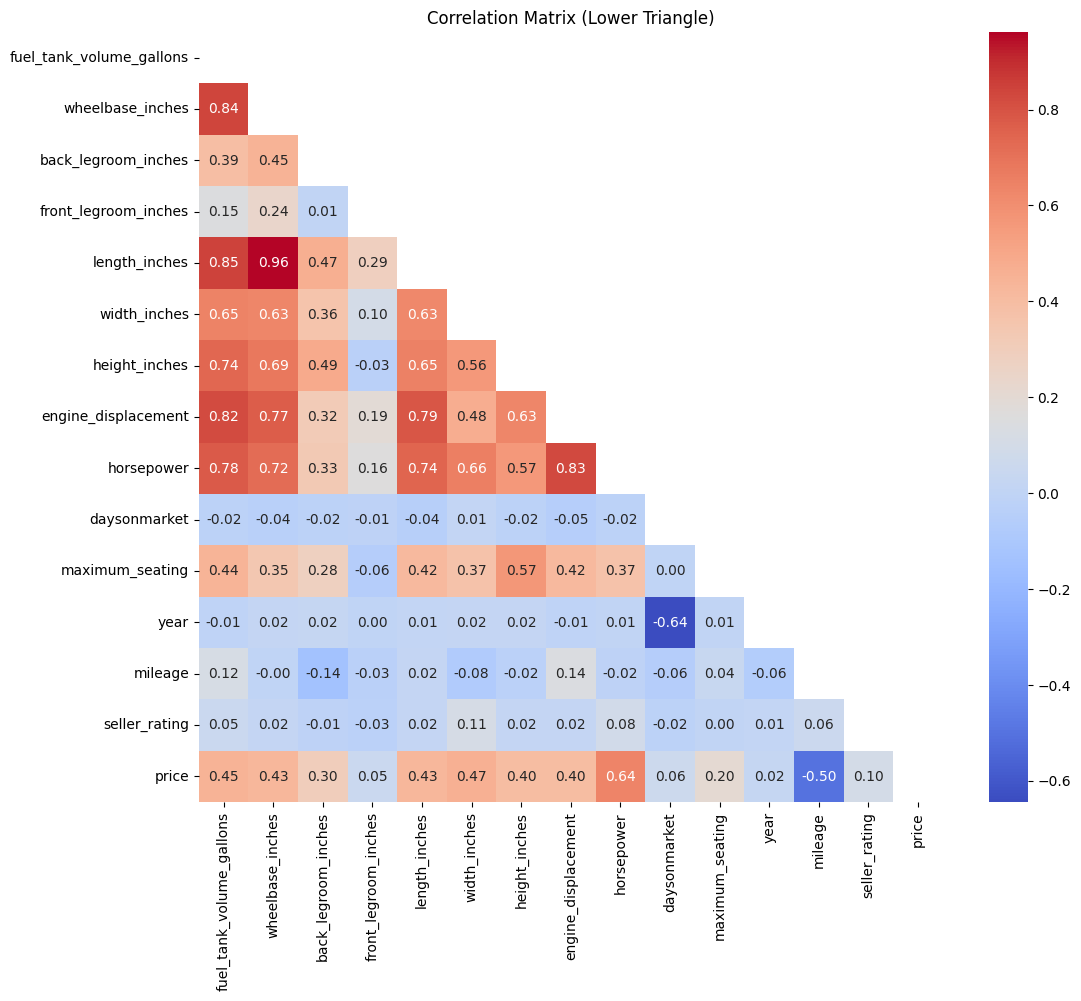

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
numerical_data = data_clean.select_dtypes(include=np.number)
numerical_data = numerical_data.drop(columns=['id'])
correlation_matrix = numerical_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, fmt=".2f")
plt.title('Correlation Matrix (Lower Triangle)')
plt.show()

In [5]:


correlation_matrix = correlation_matrix.mask(np.equal(*np.indices(correlation_matrix.shape)))
stacked_corr = correlation_matrix.stack().reset_index()

# Filter for absolute correlation values >= 0.6
high_corr = stacked_corr[stacked_corr[0].abs() >= 0.6]

# Rename columns for better readability
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
# Create a combined column for sorting and filtering
high_corr['Combined'] = high_corr.apply(lambda row: tuple(sorted((row['Variable 1'], row['Variable 2']))), axis=1)

# Keep only the first occurrence of each unique pair
high_corr = high_corr[~high_corr.duplicated(subset=['Combined'], keep='first')]

# Drop the 'Combined' column (no longer needed)
high_corr = high_corr.drop(columns=['Combined'])


# Display the result
print(high_corr)

                   Variable 1           Variable 2  Correlation
0    fuel_tank_volume_gallons     wheelbase_inches     0.842168
3    fuel_tank_volume_gallons        length_inches     0.848567
4    fuel_tank_volume_gallons         width_inches     0.645402
5    fuel_tank_volume_gallons        height_inches     0.736536
6    fuel_tank_volume_gallons  engine_displacement     0.819015
7    fuel_tank_volume_gallons           horsepower     0.777131
17           wheelbase_inches        length_inches     0.961585
18           wheelbase_inches         width_inches     0.629359
19           wheelbase_inches        height_inches     0.685472
20           wheelbase_inches  engine_displacement     0.768946
21           wheelbase_inches           horsepower     0.720626
60              length_inches         width_inches     0.625630
61              length_inches        height_inches     0.649459
62              length_inches  engine_displacement     0.790600
63              length_inches           

<ipython-input-5-5df6fabd4008>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_corr['Combined'] = high_corr.apply(lambda row: tuple(sorted((row['Variable 1'], row['Variable 2']))), axis=1)


Text Columns (Either one-hot encode for ML algorithims or find a sentiment score for the descriptions)

In [6]:
data_clean['volume_inches'] = data_clean['length_inches'] * data_clean['width_inches'] * data_clean['height_inches']
data_clean['listed_date'] = pd.to_datetime(data_clean['listed_date'])
data_clean['listing_year'] = data_clean['listed_date'].dt.year
data_clean['listing_month'] = data_clean['listed_date'].dt.month
data_clean['listing_day'] = data_clean['listed_date'].dt.day
text_columns = data_clean.select_dtypes(include=['object', 'string'])
print(text_columns.head())

   make_name      model_name                       trim_name        body_type  \
0  Chevrolet           Cruze                    LS Sedan FWD            Sedan   
1       Ford      Expedition                     XLT MAX RWD  SUV / Crossover   
2      Acura             TLX  V6 FWD with Technology Package            Sedan   
3     Toyota          Tacoma            SR V6 Double Cab 4WD     Pickup Truck   
4  Chevrolet  Silverado 1500                2LT Crew Cab RWD     Pickup Truck   

  fuel_type transmission transmission_display wheel_system  \
0  Gasoline            A            Automatic          FWD   
1  Gasoline            A            Automatic          4X2   
2  Gasoline            A    9-Speed Automatic          FWD   
3  Gasoline            A            Automatic          4WD   
4  Gasoline            A    4-Speed Automatic          RWD   

  wheel_system_display engine_type  \
0    Front-Wheel Drive          I4   
1                  4X2          V6   
2    Front-Wheel Drive    

# Label Encoding

In [7]:
text_columns = data_clean.select_dtypes(include=['object', 'string'])

# Exclude 'description' and 'major_options'
text_columns = text_columns.drop(columns=['description', 'major_options'], errors='ignore')

# Print value_counts() for each remaining text column
for column in text_columns.columns:
    print(f"\nValue Counts for '{column}':")
    print(text_columns[column].value_counts())


Value Counts for 'make_name':
make_name
Ford             5948
Chevrolet        5626
Toyota           4583
Nissan           4192
Honda            3996
Jeep             2359
Hyundai          2167
Volkswagen       1809
Kia              1786
Dodge            1594
GMC              1510
BMW              1371
Mercedes-Benz    1229
Mazda            1229
RAM              1104
Lexus            1079
Buick             914
Cadillac          840
INFINITI          836
Audi              834
Lincoln           828
Subaru            792
Acura             625
Chrysler          601
Volvo             533
Mitsubishi        481
Land Rover        433
Jaguar            195
MINI              147
Alfa Romeo         47
FIAT               45
Maserati           42
Scion              38
Genesis            32
Bentley            31
Porsche            23
Pontiac            20
Mercury            19
Hummer             19
Saturn             17
Rolls-Royce        11
Saab                7
Suzuki              4
Fisker       

In [8]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Calculate Cramér's V
correlation = cramers_v(data_clean['wheel_system'], data_clean['wheel_system_display'])

print(f"Cramér's V correlation between wheel_system and wheel_system_display: {correlation}")
correlation = cramers_v(data_clean['make_name'], data_clean['body_type'])

print(f"Cramér's V correlation between make_name and body_type: {correlation}")
correlation = cramers_v(data_clean['exterior_color'], data_clean['listing_color'])

print(f"Cramér's V correlation between exterior_color and listing_color: {correlation}")
column_pairs = [
    ('model_name', 'trim_name'),
    ('transmission', 'transmission_display'),
    ('engine_type', 'fuel_type'),('body_type','fuel_type')
]

for col1, col2 in column_pairs:
    correlation = cramers_v(data_clean[col1], data_clean[col2])
    print(f"Cramér's V correlation between {col1} and {col2}: {correlation}")

Cramér's V correlation between wheel_system and wheel_system_display: 1.0
Cramér's V correlation between make_name and body_type: 0.32555270389468755
Cramér's V correlation between exterior_color and listing_color: 0.9678898274486556
Cramér's V correlation between model_name and trim_name: 0.6482888096679202
Cramér's V correlation between transmission and transmission_display: 0.9997212716153911
Cramér's V correlation between engine_type and fuel_type: 0.9997870819558243
Cramér's V correlation between body_type and fuel_type: 0.19244630500082588


In [9]:

# Create a copy of data_clean to avoid modifying the original
dataML = data_clean.copy()

# Columns to one-hot encode
columns_to_encode = ['body_type', 'transmission', 'wheel_system', 'listing_color']
# Create dictionaries to store mappings for each column
label_mappings = {}

# Perform label encoding for each column
for column in columns_to_encode:
    unique_values = dataML[column].unique()
    label_mappings[column] = {value: i for i, value in enumerate(unique_values)}
    dataML[column] = dataML[column].map(label_mappings[column])

# Print the label mappings for reference
print("Label Mappings:")
for column, mapping in label_mappings.items():
    print(f"\n{column}:")
    for value, label in mapping.items():
        print(f"  {value}: {label}")

dataML = dataML.drop(columns=['id'])

# Print all column names
print(dataML.columns)

Label Mappings:

body_type:
  Sedan: 0
  SUV / Crossover: 1
  Pickup Truck: 2
  Coupe: 3
  Minivan: 4
  Hatchback: 5
  Wagon: 6
  Convertible: 7
  Van: 8

transmission:
  A: 0
  CVT: 1
  M: 2
  nan: 3
  Dual Clutch: 4

wheel_system:
  FWD: 0
  4X2: 1
  4WD: 2
  RWD: 3
  AWD: 4
  nan: 5

listing_color:
  black: 0
  red: 1
  silver: 2
  gray: 3
  unknown: 4
  white: 5
  gold: 6
  blue: 7
  orange: 8
  brown: 9
  teal: 10
  green: 11
  yellow: 12
  purple: 13
Index(['make_name', 'model_name', 'trim_name', 'body_type',
       'fuel_tank_volume_gallons', 'fuel_type', 'transmission',
       'transmission_display', 'wheel_system', 'wheel_system_display',
       'wheelbase_inches', 'back_legroom_inches', 'front_legroom_inches',
       'length_inches', 'width_inches', 'height_inches', 'engine_type',
       'engine_displacement', 'horsepower', 'daysonmarket', 'description',
       'exterior_color', 'major_options', 'maximum_seating', 'year',
       'franchise_dealer', 'is_new', 'listed_date', 'l

In [10]:
# Check data types of all columns
dataML['is_new'] = dataML['is_new'].astype(int)
dataML['franchise_dealer'] = (dataML['franchise_dealer'] == 'Yes').astype(int)
dataML = dataML.drop(columns=['listed_date', 'wheel_system_display', 'exterior_color'])
print(dataML.dtypes)

# Check for any non-numeric columns
non_numeric_cols = dataML.select_dtypes(exclude=['number']).columns
print("\nNon-numeric columns:", non_numeric_cols)

make_name                    object
model_name                   object
trim_name                    object
body_type                     int64
fuel_tank_volume_gallons    float64
fuel_type                    object
transmission                  int64
transmission_display         object
wheel_system                  int64
wheelbase_inches            float64
back_legroom_inches         float64
front_legroom_inches        float64
length_inches               float64
width_inches                float64
height_inches               float64
engine_type                  object
engine_displacement         float64
horsepower                  float64
daysonmarket                  int64
description                  object
major_options                object
maximum_seating               int64
year                          int64
franchise_dealer              int64
is_new                        int64
listing_color                 int64
mileage                     float64
seller_rating               

# Modeling Outcomes

Selecting the best Model: We try 2 seperate NN approaches (RandomForest = Majority rules is the decision taken) & (XGBoost = Learning from mistakes)

In [11]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Assuming 'price' is your target variable
y = dataML['price']
X = dataML.select_dtypes(include=['number']).drop(columns=['price'])  # Select numeric features and drop target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost model
baseline_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Baseline Model (XGBoost) RMSE: {baseline_rmse}")

Baseline Model (XGBoost) RMSE: 4407.266358667425


In [20]:
# Assuming 'price' is your target variable and dataML is your DataFrame with selected features
y = dataML['price']
X = dataML.select_dtypes(include=['number']).drop(columns=['price'])  # Select numeric features and drop target
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary of models to evaluate
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} RMSE: {rmse}")

Random Forest RMSE: 4319.255190135232
Gradient Boosting RMSE: 6148.010690167036
Extra Trees RMSE: 4168.205945375035


In [14]:
importances = baseline_model.feature_importances_
# Get feature names from the original training data used to fit baseline_model
feature_names = baseline_model.get_booster().feature_names
# OR
# If you want to use the reduced features for importance
# feature_names = X_train.columns  # Use columns from current X_train
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                     Feature  Importance
11                horsepower    0.379548
18                   mileage    0.140867
16                    is_new    0.119216
0                  body_type    0.076595
10       engine_displacement    0.050684
3               wheel_system    0.047606
13           maximum_seating    0.033211
8               width_inches    0.029116
6       front_legroom_inches    0.021959
5        back_legroom_inches    0.017443
1   fuel_tank_volume_gallons    0.014824
4           wheelbase_inches    0.013946
9              height_inches    0.013305
7              length_inches    0.011535
20             volume_inches    0.009547
12              daysonmarket    0.005429
19             seller_rating    0.005410
22             listing_month    0.003812
14                      year    0.002238
17             listing_color    0.001398
23               listing_day    0.001201
2               transmission    0.001110
15          franchise_dealer    0.000000
21              

Iteration Strategy: We temporarily exclude a feature then train the model. If the model's RMSE improves then we permanently remove the feature.

In [15]:
# Initialize list of selected features
selected_features = list(X.columns)

# Iterate through features, adding or removing based on RMSE impact
for feature in X.columns:
    # Create a temporary feature set with the current feature removed
    temp_features = selected_features.copy()
    if feature in temp_features:
        temp_features.remove(feature)
    else:
        temp_features.append(feature)

    # Train and evaluate a model with the temporary feature set
    X_train_temp = X_train[temp_features]
    X_test_temp = X_test[temp_features]
    temp_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    temp_model.fit(X_train_temp, y_train)
    y_pred_temp = temp_model.predict(X_test_temp)
    temp_rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))

    # Update selected features if RMSE improves
    if temp_rmse < baseline_rmse:
        selected_features = temp_features
        baseline_rmse = temp_rmse
        print(f"Feature '{feature}' {'removed' if feature not in selected_features else 'added'}, RMSE improved to: {baseline_rmse}")
    else:
        print(f"Feature '{feature}' {'added' if feature not in selected_features else 'removed'}, RMSE did not improve.")

# Print final selected features and RMSE
print("\nFinal selected features:", selected_features)
print("Final RMSE:", baseline_rmse)

Feature 'body_type' removed, RMSE improved to: 4376.38220755463
Feature 'fuel_tank_volume_gallons' removed, RMSE did not improve.
Feature 'transmission' removed, RMSE improved to: 4340.4895694053785
Feature 'wheel_system' removed, RMSE did not improve.
Feature 'wheelbase_inches' removed, RMSE did not improve.
Feature 'back_legroom_inches' removed, RMSE did not improve.
Feature 'front_legroom_inches' removed, RMSE improved to: 4305.818576328242
Feature 'length_inches' removed, RMSE did not improve.
Feature 'width_inches' removed, RMSE did not improve.
Feature 'height_inches' removed, RMSE did not improve.
Feature 'engine_displacement' removed, RMSE did not improve.
Feature 'horsepower' removed, RMSE did not improve.
Feature 'daysonmarket' removed, RMSE improved to: 4299.180266908005
Feature 'maximum_seating' removed, RMSE did not improve.
Feature 'year' removed, RMSE did not improve.
Feature 'franchise_dealer' removed, RMSE did not improve.
Feature 'is_new' removed, RMSE did not improve

In [21]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

# Define a dictionary of models to evaluate
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42)
}

for model_name, model in models.items():
    print(f"\nEvaluating feature selection for {model_name}:")

    # Initialize list of selected features
    selected_features = list(X.columns)

    # Train and evaluate initial model to get baseline RMSE
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Baseline RMSE: {baseline_rmse}")

    # Iterate through features, adding or removing based on RMSE impact
    for feature in X.columns:
        # Create a temporary feature set with the current feature removed
        temp_features = selected_features.copy()
        if feature in temp_features:
            temp_features.remove(feature)
        else:
            temp_features.append(feature)

        # Train and evaluate a model with the temporary feature set
        X_train_temp = X_train[temp_features]
        X_test_temp = X_test[temp_features]
        temp_model = model  # Use the current model (RandomForest or ExtraTrees)
        temp_model.fit(X_train_temp, y_train)
        y_pred_temp = temp_model.predict(X_test_temp)
        temp_rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))

        # Update selected features if RMSE improves
        if temp_rmse < baseline_rmse:
            selected_features = temp_features
            baseline_rmse = temp_rmse
            print(f"Feature '{feature}' {'removed' if feature not in selected_features else 'added'}, RMSE improved to: {baseline_rmse}")
        else:
            print(f"Feature '{feature}' {'added' if feature not in selected_features else 'removed'}, RMSE did not improve.")

    # Print final selected features and RMSE for the current model
    print(f"\nFinal selected features for {model_name}:", selected_features)
    print(f"Final RMSE for {model_name}:", baseline_rmse)


Evaluating feature selection for Random Forest:
Baseline RMSE: 4319.255190135232
Feature 'body_type' removed, RMSE did not improve.
Feature 'fuel_tank_volume_gallons' removed, RMSE did not improve.
Feature 'transmission' removed, RMSE did not improve.
Feature 'wheel_system' removed, RMSE did not improve.
Feature 'wheelbase_inches' removed, RMSE did not improve.
Feature 'back_legroom_inches' removed, RMSE did not improve.
Feature 'front_legroom_inches' removed, RMSE did not improve.
Feature 'length_inches' removed, RMSE did not improve.
Feature 'width_inches' removed, RMSE did not improve.
Feature 'height_inches' removed, RMSE did not improve.
Feature 'engine_displacement' removed, RMSE improved to: 4246.197911739919
Feature 'horsepower' removed, RMSE did not improve.
Feature 'daysonmarket' removed, RMSE did not improve.
Feature 'maximum_seating' removed, RMSE did not improve.
Feature 'year' removed, RMSE did not improve.
Feature 'franchise_dealer' removed, RMSE did not improve.
Featur

# Description and Major_Options Model

Now that we have some idea of how XGBRegressor is working, let's include some of what was in Major Options and Description.

In [33]:
from collections import Counter

# 1. Unlist and Count Major Options
all_options = []
for index in dataML.index:
    options = dataML.loc[index, 'major_options']
    if isinstance(options, str):  # Check if it's a string (not NaN)
        options_list = options.strip('[]').replace("'", "").split(', ')
        all_options.extend(options_list)

option_counts = Counter(all_options)

# 2. Get Top 10 Features
top_10_features = [feature for feature, count in option_counts.most_common(10)]

# 3. One-Hot Encode Top 10 Features
for feature in top_10_features:
    dataML[f'has_{feature}'] = dataML['major_options'].apply(
        lambda x: 1 if isinstance(x, str) and feature in x else 0
    )

# Print option counts and top 10 features (optional)
print("Option Counts:", option_counts)
print("\nTop 10 Features:", top_10_features)

Option Counts: Counter({'Backup Camera': 37458, 'Bluetooth': 33629, 'Alloy Wheels': 30829, 'Heated Seats': 20194, 'Navigation System': 17608, 'Sunroof/Moonroof': 17105, 'Remote Start': 15356, 'CarPlay': 15114, 'Blind Spot Monitoring': 13943, 'Leather Seats': 13877, 'Android Auto': 13465, 'Adaptive Cruise Control': 9176, 'Parking Sensors': 8356, 'Third Row Seating': 6099, 'Steel Wheels': 3941, 'Quick Order Package': 3600, 'Premium Package': 3504, 'Convenience Package': 3396, 'Power Package': 1959, 'Tow Package': 1918, 'Technology Package': 1751, 'Appearance Package': 1744, 'Multi Zone Climate Control': 1738, 'Preferred Package': 1472, 'Heat Package': 1314, 'SE Package': 1279, 'Premium Wheels': 1138, 'Cold Weather Package': 1122, 'Sport Package': 1105, 'Off Road Package': 981, 'Cargo Package': 943, 'Adaptive Suspension': 924, 'Chrome Wheels': 810, 'Suspension Package': 728, 'Trailer Package': 699, 'LE Package': 698, 'Luxury Package': 642, 'Driver Assistance Package': 592, 'Comfort Packag

In [34]:
dataML.columns

Index(['make_name', 'model_name', 'trim_name', 'body_type',
       'fuel_tank_volume_gallons', 'fuel_type', 'transmission',
       'transmission_display', 'wheel_system', 'wheelbase_inches',
       'back_legroom_inches', 'front_legroom_inches', 'length_inches',
       'width_inches', 'height_inches', 'engine_type', 'engine_displacement',
       'horsepower', 'daysonmarket', 'description', 'major_options',
       'maximum_seating', 'year', 'franchise_dealer', 'is_new',
       'listing_color', 'mileage', 'seller_rating', 'price', 'volume_inches',
       'listing_year', 'listing_month', 'listing_day', 'has_Backup Camera',
       'has_Bluetooth', 'has_Alloy Wheels', 'has_Heated Seats',
       'has_Navigation System', 'has_Sunroof/Moonroof', 'has_Remote Start',
       'has_CarPlay', 'has_Blind Spot Monitoring', 'has_Leather Seats'],
      dtype='object')

In [37]:
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Check if text is a string before processing
    if isinstance(text, str):
        # Lowercase the text
        text = text.lower()
        # Remove stop words
        text = ' '.join([word for word in text.split() if word not in stop_words])
        # Remove excessive whitespace
        text = re.sub(' +', ' ', text)
        return text
    else:
        return text  # Return the original value if it's not a string

dataML['description_processed'] = dataML['description'].apply(preprocess_text)

print(dataML[['description', 'description_processed']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                         description  \
0  This Chevrolet won't be on the lot long! This ...   
1  Recent Arrival!110V/150W AC Power Outlet, 2 Sm...   
2  This 2018 Acura TLX 3.5L V6 in Silver Metallic...   
3  *DESIRABLE FEATURES:* 4X4, BACKUP CAMERA, BLUE...   
4  Grille Color - Chrome, Rear Bumper Color - Chr...   

                               description_processed  
0  chevrolet lot long! car stands crowd, boasting...  
1  recent arrival!110v/150w ac power outlet, 2 sm...  
2  2018 acura tlx 3.5l v6 silver metallic feature...  
3  *desirable features:* 4x4, backup camera, blue...  
4  grille color - chrome, rear bumper color - chr...  


TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'pandas._libs.missing.NAType'>

In [46]:
from collections import Counter
import string

# Combine all processed descriptions into a single string
all_text = ' '.join(dataML['description_processed'].astype(str).tolist())

# Tokenize the text into individual words
words = all_text.split()

# Remove punctuation from words
words = [word for word in words if word not in string.punctuation]

# Count the frequency of each word
word_counts = Counter(words)

# Get the top 11 most frequent words
top_11_keywords = word_counts.most_common(11)

# Exclude the 2nd entry (index 1) and get the remaining top 10
top_10_keywords = [keyword for i, keyword in enumerate(top_11_keywords) if i != 1]

# Print the top 10 keywords and their counts
print("Top 10 Keywords:")
for keyword, count in top_10_keywords[:10]:  # Slice to get only top 10
    print(f"- {keyword}: {count}")

Top 10 Keywords (excluding the 2nd most frequent):
- front: 231840
- door: 180552
- steering: 133240
- power: 121975
- air: 120310
- wheel: 112039
- seat: 91626
- driver: 88387
- audio: 82857
- vanity: 81809


In [48]:
# Check for empty strings in 'description_processed'
empty_descriptions = dataML[dataML['description_processed'] == '']

# Print the number of empty descriptions
print(f"Number of empty descriptions: {len(empty_descriptions)}")

Number of empty descriptions: 0


In [49]:
# Check for whitespace-only strings in 'description_processed'
whitespace_descriptions = dataML[dataML['description_processed'].str.strip() == '']

# Print the number of whitespace-only descriptions
print(f"Number of whitespace-only descriptions: {len(whitespace_descriptions)}")

Number of whitespace-only descriptions: 0


In [50]:
# Check the data type of 'description_processed'
print(dataML['description_processed'].dtype)

object


In [51]:
dataML['description_processed'] = dataML['description_processed'].astype('string')

In [52]:
from textblob import TextBlob

def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0  # Or any other default value

dataML['description_sentiment'] = dataML['description_processed'].apply(get_sentiment)

In [53]:
print(dataML[['description_processed', 'description_sentiment']].head())

                               description_processed  description_sentiment
0  chevrolet lot long! car stands crowd, boasting...               0.595000
1  recent arrival!110v/150w ac power outlet, 2 sm...               0.057764
2  2018 acura tlx 3.5l v6 silver metallic feature...               0.104996
3  *desirable features:* 4x4, backup camera, blue...               0.171975
4  grille color - chrome, rear bumper color - chr...               0.005500


In [54]:
dataML.columns

Index(['make_name', 'model_name', 'trim_name', 'body_type',
       'fuel_tank_volume_gallons', 'fuel_type', 'transmission',
       'transmission_display', 'wheel_system', 'wheelbase_inches',
       'back_legroom_inches', 'front_legroom_inches', 'length_inches',
       'width_inches', 'height_inches', 'engine_type', 'engine_displacement',
       'horsepower', 'daysonmarket', 'description', 'major_options',
       'maximum_seating', 'year', 'franchise_dealer', 'is_new',
       'listing_color', 'mileage', 'seller_rating', 'price', 'volume_inches',
       'listing_year', 'listing_month', 'listing_day', 'has_Backup Camera',
       'has_Bluetooth', 'has_Alloy Wheels', 'has_Heated Seats',
       'has_Navigation System', 'has_Sunroof/Moonroof', 'has_Remote Start',
       'has_CarPlay', 'has_Blind Spot Monitoring', 'has_Leather Seats',
       'description_processed', 'description_sentiment'],
      dtype='object')

#Experimenting with more data

In [55]:
y = dataML['price']
X = dataML.select_dtypes(include=['number']).drop(columns=['price'])  # Select numeric features and drop target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost model
baseline_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = baseline_model.predict(X_test)

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Baseline Model (XGBoost) RMSE: {baseline_rmse}")

Baseline Model (XGBoost) RMSE: 3971.1675876326494


In [56]:
# Assuming 'price' is your target variable and dataML is your DataFrame with selected features
y = dataML['price']
X = dataML.select_dtypes(include=['number']).drop(columns=['price'])  # Select numeric features and drop target
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary of models to evaluate
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} RMSE: {rmse}")

Random Forest RMSE: 4168.369951022441
Gradient Boosting RMSE: 5780.511523485578
Extra Trees RMSE: 3945.2581623380515


In [57]:
# Initialize list of selected features
selected_features = list(X.columns)

# Iterate through features, adding or removing based on RMSE impact
for feature in X.columns:
    # Create a temporary feature set with the current feature removed
    temp_features = selected_features.copy()
    if feature in temp_features:
        temp_features.remove(feature)
    else:
        temp_features.append(feature)

    # Train and evaluate a model with the temporary feature set
    X_train_temp = X_train[temp_features]
    X_test_temp = X_test[temp_features]
    temp_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    temp_model.fit(X_train_temp, y_train)
    y_pred_temp = temp_model.predict(X_test_temp)
    temp_rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))

    # Update selected features if RMSE improves
    if temp_rmse < baseline_rmse:
        selected_features = temp_features
        baseline_rmse = temp_rmse
        print(f"Feature '{feature}' {'removed' if feature not in selected_features else 'added'}, RMSE improved to: {baseline_rmse}")
    else:
        print(f"Feature '{feature}' {'added' if feature not in selected_features else 'removed'}, RMSE did not improve.")

# Print final selected features and RMSE
print("\nFinal selected features:", selected_features)
print("Final RMSE:", baseline_rmse)

Feature 'body_type' removed, RMSE did not improve.
Feature 'fuel_tank_volume_gallons' removed, RMSE did not improve.
Feature 'transmission' removed, RMSE did not improve.
Feature 'wheel_system' removed, RMSE did not improve.
Feature 'wheelbase_inches' removed, RMSE did not improve.
Feature 'back_legroom_inches' removed, RMSE did not improve.
Feature 'front_legroom_inches' removed, RMSE did not improve.
Feature 'length_inches' removed, RMSE did not improve.
Feature 'width_inches' removed, RMSE did not improve.
Feature 'height_inches' removed, RMSE did not improve.
Feature 'engine_displacement' removed, RMSE did not improve.
Feature 'horsepower' removed, RMSE did not improve.
Feature 'daysonmarket' removed, RMSE did not improve.
Feature 'maximum_seating' removed, RMSE did not improve.
Feature 'year' removed, RMSE did not improve.
Feature 'franchise_dealer' removed, RMSE did not improve.
Feature 'is_new' removed, RMSE did not improve.
Feature 'listing_color' removed, RMSE improved to: 393

In [58]:
# Define a dictionary of models to evaluate
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42)
}

for model_name, model in models.items():
    print(f"\nEvaluating feature selection for {model_name}:")

    # Initialize list of selected features
    selected_features = list(X.columns)

    # Train and evaluate initial model to get baseline RMSE
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Baseline RMSE: {baseline_rmse}")

    # Iterate through features, adding or removing based on RMSE impact
    for feature in X.columns:
        # Create a temporary feature set with the current feature removed
        temp_features = selected_features.copy()
        if feature in temp_features:
            temp_features.remove(feature)
        else:
            temp_features.append(feature)

        # Train and evaluate a model with the temporary feature set
        X_train_temp = X_train[temp_features]
        X_test_temp = X_test[temp_features]
        temp_model = model  # Use the current model (RandomForest or ExtraTrees)
        temp_model.fit(X_train_temp, y_train)
        y_pred_temp = temp_model.predict(X_test_temp)
        temp_rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))

        # Update selected features if RMSE improves
        if temp_rmse < baseline_rmse:
            selected_features = temp_features
            baseline_rmse = temp_rmse
            print(f"Feature '{feature}' {'removed' if feature not in selected_features else 'added'}, RMSE improved to: {baseline_rmse}")
        else:
            print(f"Feature '{feature}' {'added' if feature not in selected_features else 'removed'}, RMSE did not improve.")

    # Print final selected features and RMSE for the current model
    print(f"\nFinal selected features for {model_name}:", selected_features)
    print(f"Final RMSE for {model_name}:", baseline_rmse)


Evaluating feature selection for Random Forest:
Baseline RMSE: 4168.369951022441
Feature 'body_type' removed, RMSE improved to: 4163.803208695501
Feature 'fuel_tank_volume_gallons' removed, RMSE did not improve.
Feature 'transmission' removed, RMSE did not improve.
Feature 'wheel_system' removed, RMSE did not improve.
Feature 'wheelbase_inches' removed, RMSE did not improve.
Feature 'back_legroom_inches' removed, RMSE did not improve.
Feature 'front_legroom_inches' removed, RMSE did not improve.
Feature 'length_inches' removed, RMSE did not improve.
Feature 'width_inches' removed, RMSE did not improve.
Feature 'height_inches' removed, RMSE did not improve.
Feature 'engine_displacement' removed, RMSE improved to: 4050.993802906031
Feature 'horsepower' removed, RMSE did not improve.
Feature 'daysonmarket' removed, RMSE improved to: 4016.254284103905
Feature 'maximum_seating' removed, RMSE improved to: 3978.9432692761734
Feature 'year' removed, RMSE did not improve.
Feature 'franchise_de

In [59]:
from sklearn.model_selection import RandomizedSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=100,  # Number of random combinations to try
    scoring='neg_root_mean_squared_error',  # Use RMSE as the scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Print progress messages
    random_state=42,  # Set random state for reproducibility
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

In [62]:
# Assuming you have X_train, y_train defined with the selected features:
selected_features = ['fuel_tank_volume_gallons', 'transmission', 'wheel_system', 'wheelbase_inches', 'back_legroom_inches', 'front_legroom_inches', 'length_inches', 'width_inches', 'height_inches', 'horsepower', 'year', 'is_new', 'listing_color', 'mileage', 'seller_rating', 'listing_year', 'listing_month', 'has_Backup Camera', 'has_Alloy Wheels', 'has_Heated Seats', 'has_Navigation System', 'has_Sunroof/Moonroof', 'has_Remote Start', 'has_CarPlay', 'has_Blind Spot Monitoring', 'has_Leather Seats', 'description_sentiment']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fit the RandomizedSearchCV object
random_search.fit(X_train_selected, y_train)
# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the model on the test set
y_pred = best_model.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with Optimized Hyperparameters: {rmse}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

# Displaying the model made to a UI

In [63]:
selected_features = ['fuel_tank_volume_gallons', 'transmission', 'wheel_system', 'wheelbase_inches', 'back_legroom_inches', 'front_legroom_inches', 'length_inches', 'width_inches', 'height_inches', 'horsepower', 'year', 'is_new', 'listing_color', 'mileage', 'seller_rating', 'listing_year', 'listing_month', 'has_Backup Camera', 'has_Alloy Wheels', 'has_Heated Seats', 'has_Navigation System', 'has_Sunroof/Moonroof', 'has_Remote Start', 'has_CarPlay', 'has_Blind Spot Monitoring', 'has_Leather Seats', 'description_sentiment']

# Create a new RandomForestRegressor with optimized hyperparameters (if you have them)
# or use default hyperparameters
rf_model = RandomForestRegressor(random_state=42) # You can add hyperparameters here


X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fit the model to the training data with selected features
rf_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_selected)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE with selected features: {rmse}")

Random Forest RMSE with selected features: 3840.0074960024735


In [64]:
# Get feature importances from the trained rf_model
importances = rf_model.feature_importances_

# Create a DataFrame to store feature importances along with feature names
feature_importances_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importances
print(feature_importances_df)

                      Feature  Importance
9                  horsepower    0.475587
13                    mileage    0.258829
21       has_Sunroof/Moonroof    0.036822
11                     is_new    0.028999
6               length_inches    0.027241
8               height_inches    0.020685
7                width_inches    0.019169
0    fuel_tank_volume_gallons    0.017164
3            wheelbase_inches    0.016746
5        front_legroom_inches    0.015705
20      has_Navigation System    0.014733
4         back_legroom_inches    0.013928
2                wheel_system    0.010003
14              seller_rating    0.009293
26      description_sentiment    0.007859
16              listing_month    0.005007
17          has_Backup Camera    0.003944
12              listing_color    0.002998
19           has_Heated Seats    0.002721
10                       year    0.002658
15               listing_year    0.002502
25          has_Leather Seats    0.002031
24  has_Blind Spot Monitoring    0

In [74]:
import gradio as gr
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib  # Import joblib for saving/loading the scaler


def predict_price(year, mileage, horsepower, transmission, wheel_system, fuel_tank_volume, listing_color, seller_rating, has_backup_camera, has_alloy_wheels):
    # Create a DataFrame with user inputs
    input_data = pd.DataFrame({
        'year': [year],
        'mileage': [mileage],
        'horsepower': [horsepower],
        'transmission': [transmission],
        'wheel_system': [wheel_system],
        'fuel_tank_volume_gallons': [fuel_tank_volume],
        'listing_color': [listing_color],
        'seller_rating': [seller_rating],
        'has_Backup Camera': [has_backup_camera],
        'has_Alloy Wheels': [has_alloy_wheels]
    })

    # Apply transmission mapping
    transmission_mapping = {"Automatic": 0, "Manual": 1}
    input_data['transmission'] = input_data['transmission'].map(transmission_mapping)

    # Load and apply the scaler (Make sure 'scaler.pkl' exists and was created during training)
    scaler = joblib.load('scaler.pkl')
    numerical_features = ['mileage', 'horsepower', 'fuel_tank_volume_gallons']
    input_data[numerical_features] = scaler.transform(input_data[numerical_features])

    # Make prediction
    predicted_price = rf_model.predict(input_data)[0]

    return f"Predicted Price: ${predicted_price:.2f}"


# Define Gradio interface
min_year = int(dataML['year'].min())
max_year = int(dataML['year'].max())
min_mileage = int(dataML['mileage'].min())
max_mileage = int(dataML['mileage'].max())
min_horsepower = int(dataML['horsepower'].min())
max_horsepower = int(dataML['horsepower'].max())
min_fuel_tank_volume = int(dataML['fuel_tank_volume_gallons'].min())
max_fuel_tank_volume = int(dataML['fuel_tank_volume_gallons'].max())

iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Slider(minimum=min_year, maximum=max_year, step=1, default=min_year, label="Year"),
        gr.Slider(minimum=min_mileage, maximum=max_mileage, step=1, default=min_mileage, label="Mileage"),
        gr.Slider(minimum=min_horsepower, maximum=max_horsepower, step=1, default=min_horsepower, label="Horsepower"),
        gr.inputs.Dropdown(["Automatic", "Manual"], label="Transmission"),
        gr.inputs.Dropdown(["AWD", "FWD", "RWD"], label="Wheel System"),
        gr.Slider(minimum=min_fuel_tank_volume, maximum=max_fuel_tank_volume, step=1, default=min_fuel_tank_volume,
                  label="Fuel Tank Volume (Gallons)"),
        gr.inputs.Dropdown(["Black", "White", "Silver", "Gray", "Red", "Blue"], label="Listing Color"),
        gr.inputs.Slider(1, 5, step=0.1, label="Seller Rating"),
        gr.inputs.Checkbox(label="Has Backup Camera"),
        gr.inputs.Checkbox(label="Has Alloy Wheels")
    ],
    outputs="number",
    title="Car Price Predictor"
)

iface.launch()

<ipython-input-74-6072a28580e2>:50: UserWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 2018}
  gr.Slider(minimum=min_year, maximum=max_year, step=1, default=min_year, label="Year"),
<ipython-input-74-6072a28580e2>:51: UserWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 0}
  gr.Slider(minimum=min_mileage, maximum=max_mileage, step=1, default=min_mileage, label="Mileage"),
<ipython-input-74-6072a28580e2>:52: UserWarning: You have unused kwarg parameters in Slider, please remove them: {'default': 74}
  gr.Slider(minimum=min_horsepower, maximum=max_horsepower, step=1, default=min_horsepower, label="Horsepower"),
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:219: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:222: UserWarning: `optional` 

IMPORTANT: You are using gradio version 3.35.2, however version 4.44.1 is available, please upgrade.
--------
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>